# Set-Up and Imports

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import itertools
from arraytainers import Arraytainer
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plotting settings:

In [3]:
# Plot theme:
sns.set_theme(style='darkgrid')
palette = sns.color_palette()

y-limits of APE plots:

In [4]:
ape_ylims = (-1.6, -0.6)

Save directory for figures:

In [5]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)
data_save_dir = './data/noise_prior'
if not os.path.isdir(data_save_dir):
    os.makedirs(data_save_dir)

Random seeds:

In [6]:
jax_rng = jax.random.PRNGKey(42)
np_seed = 42

# Effect of Noise

For the purposes of playing around with noise and the prior, we'll stick with our local linearisation posterior since it performed the best. Let's now load our beam model and create a minimiser for our Laplace approximation:

In [7]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
minimizer = oed_toolbox.optim.gradient_descent_for_map(lr=1e-4)

Let's now plot the APE landscape for different amounts of noise:

In [8]:
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
num_samples = 1000
noise_cov_list = jnp.linspace(0.001, 0.01, 10)
d_vals = jnp.linspace(0,1,50)
ape_noise = []
for noise_cov in noise_cov_list:
    print(f'Computing APE loss landscape for noise_cov = {noise_cov}')
    likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_noise.append(ape_vals)

noise_experiment = {'noise_cov': noise_cov_list, 'd': d_vals, 'ape': ape_noise}

with open(os.path.join(data_save_dir, 'ape_noise.json'), 'w') as f:
    json.dump(Arraytainer(noise_experiment).tolist(), f, indent=4)

Computing APE loss landscape for noise_cov = 0.0010000000474974513


KeyboardInterrupt: 

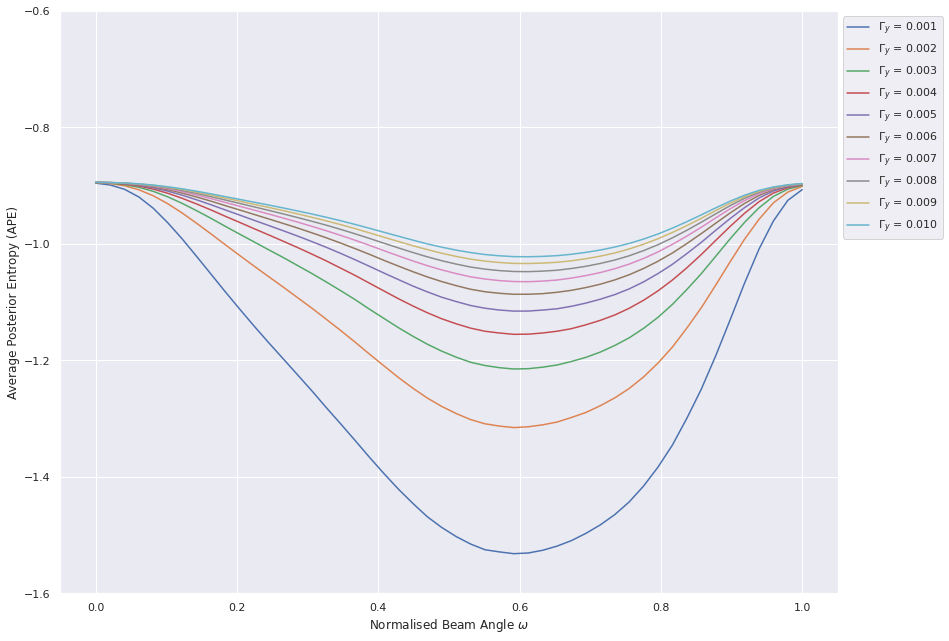

In [18]:
with open(os.path.join(data_save_dir, 'ape_noise.json'), 'r') as f:
    noise_experiment = json.load(f)

fig, ax = plt.subplots()
for i, (noise_cov, ape_i) in enumerate(zip(noise_experiment['noise_cov'], noise_experiment['ape'])):
    sns.lineplot(x=np.array(noise_experiment['d']).squeeze(), y=np.array(ape_i).squeeze(), 
                 color=palette[i], label=f'$\Gamma_y$ = {noise_cov:.3f}')
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
ax.set_ylim(*ape_ylims)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
fig.set_size_inches(.5, 10.5, forward=True)
plt.savefig(os.path.join(fig_save_dir, 'noise_effect.pdf'), bbox_inches='tight')

# Effect of Prior

We need to be careful when changing our prior - if we're not, we could sample in regions where our surrogate is exptrapolating.

In [11]:
prior_cov_list= jnp.linspace(0.005, 0.015, 10)
prior_mean_list = jnp.linspace(0.3, 0.7, 10)
prior_combos = list(itertools.product(prior_mean_list, prior_cov_list))

Let's check to see how much the widest priors near the boundaries of the $[0, 1]$ 'poke out':

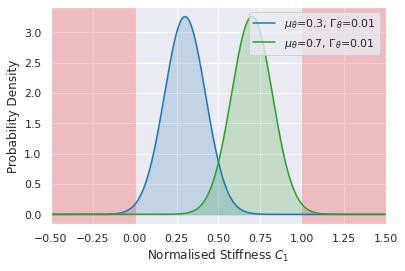

In [12]:
prior_low = oed_toolbox.distributions.Prior.gaussian(prior_mean_list[0], prior_cov_list[-1])
prior_high = oed_toolbox.distributions.Prior.gaussian(prior_mean_list[-1], prior_cov_list[-1])
theta_plot = jnp.linspace(-0.5, 1.5, 1000).reshape(-1,1)

logpdf_1 = prior_low.logpdf(theta_plot)['logpdf']
logpdf_2 = prior_high.logpdf(theta_plot)['logpdf']
pdfs = \
{f'$\\mu_\\theta$={prior_mean_list[0]:.1f}, $\\Gamma_\\theta$={prior_cov_list[-1]:.2f}': jnp.exp(logpdf_1),
 f'$\\mu_\\theta$={prior_mean_list[-1]:.1f}, $\\Gamma_\\theta$={prior_cov_list[-1]:.2f}': jnp.exp(logpdf_2)}
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$', color_idx=[0,2])
ax = plt.gca()
# Highlight extrapolation regions:
ax.axvspan(-0.5, 0, alpha=0.2, color='red')
ax.axvspan(1, 1.5, alpha=0.2, color='red')
ax.set_xlim(-0.5, 1.5)
# Slightly shift legend to the right
leg = plt.legend(loc='upper right')
# bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# xOffset = 0.08
# bb.x0 += xOffset
# bb.x1 += xOffset
# leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
plt.savefig(os.path.join(fig_save_dir, 'prior_bounds_check.pdf'), bbox_inches='tight')

Although these priors force our GP to extrapolate, it doesn't appear that it's doing this excessively. Let's now compute each loss landscape for each prior

In [11]:
noise_cov = 0.005
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
num_samples = 1000
d_vals = jnp.linspace(0,1,50)
ape_prior, prior_means, prior_covs = [], [], []
for i, (prior_mean, prior_cov) in enumerate(prior_combos):
    print(f'Computing APE loss landscape for prior {i+1}/{len(prior_combos)} (mean = {prior_mean:.2f}, cov = {prior_cov:.4f})')
    prior_means.append(prior_mean)
    prior_covs.append(prior_cov)
    prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
    laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, 
                                                                               noise_cov, prior_mean, prior_cov)
    laplace_ape = oed_toolbox.losses.APE(prior, likelihood, laplace_approx, use_reparameterisation=True)
    ape_vals = []
    for i, d in enumerate(d_vals):
        ape_vals.append(laplace_ape(d, num_samples=num_samples, rng=np.random.default_rng(np_seed), return_grad=False))
    ape_prior.append(ape_vals)

prior_experiment = {'mean': prior_means, 'cov': prior_covs, 'ape': ape_prior, 'd': d_vals}

with open(os.path.join(data_save_dir, 'ape_prior.json'), 'w') as f:
    json.dump(Arraytainer(prior_experiment).tolist(), f, indent=4)

Computing APE loss landscape for prior 1/100 (mean = 0.30, cov = 0.0050)
Computing APE loss landscape for prior 2/100 (mean = 0.30, cov = 0.0061)
Computing APE loss landscape for prior 3/100 (mean = 0.30, cov = 0.0072)
Computing APE loss landscape for prior 4/100 (mean = 0.30, cov = 0.0083)
Computing APE loss landscape for prior 5/100 (mean = 0.30, cov = 0.0094)
Computing APE loss landscape for prior 6/100 (mean = 0.30, cov = 0.0106)
Computing APE loss landscape for prior 7/100 (mean = 0.30, cov = 0.0117)
Computing APE loss landscape for prior 8/100 (mean = 0.30, cov = 0.0128)
Computing APE loss landscape for prior 9/100 (mean = 0.30, cov = 0.0139)
Computing APE loss landscape for prior 10/100 (mean = 0.30, cov = 0.0150)
Computing APE loss landscape for prior 11/100 (mean = 0.34, cov = 0.0050)
Computing APE loss landscape for prior 12/100 (mean = 0.34, cov = 0.0061)
Computing APE loss landscape for prior 13/100 (mean = 0.34, cov = 0.0072)
Computing APE loss landscape for prior 14/100 (

KeyboardInterrupt: 

First, let's fix the mean and plot the effect of changing the covariance:

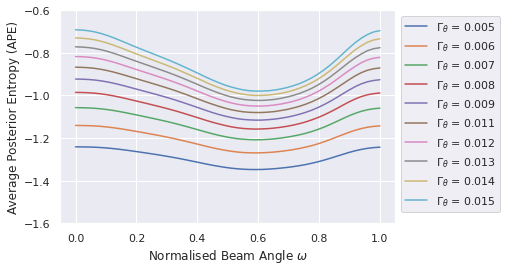

In [13]:
with open(os.path.join(data_save_dir, 'ape_prior.json'), 'r') as f:
    prior_experiment = json.load(f)

mean_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
mean_to_plot = np.unique(prior_experiment['mean'])[mean_idx_to_plot]
for i, mean in enumerate(prior_experiment['mean']):
    if np.isclose(mean, mean_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_cov = prior_experiment['cov'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\Gamma_\\theta$ = {prior_cov:.3f}')
            num_plotted += 1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1)) # 
ax.set_ylim(*ape_ylims)
ax.set_aspect(0.7)
plt.savefig(os.path.join(fig_save_dir, 'prior_cov_effect.pdf'), bbox_inches='tight')

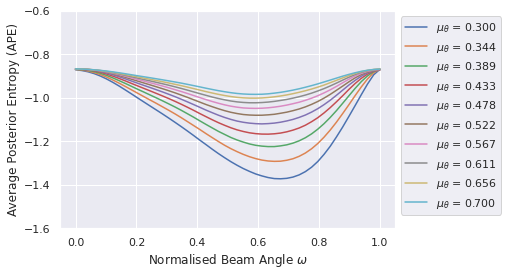

In [12]:
with open(os.path.join(data_save_dir, 'ape_prior.json'), 'r') as f:
    prior_experiment = json.load(f)

cov_idx_to_plot = 5
plot_freq = 1
fig, ax = plt.subplots()
num_plotted = num_found = 0
cov_to_plot = np.unique(prior_experiment['cov'])[cov_idx_to_plot]
for i, cov in enumerate(prior_experiment['cov']):
    if np.isclose(cov, cov_to_plot):
        if num_found % plot_freq == 0:
            ape_i = np.array(prior_experiment['ape'])[i,:]
            prior_mean = prior_experiment['mean'][i]
            sns.lineplot(x=np.array(prior_experiment['d']).squeeze(), y=ape_i.squeeze(), 
                         color=palette[num_plotted], label=f'$\mu_\\theta$ = {prior_mean:.3f}')
            num_plotted+=1
        num_found += 1
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Average Posterior Entropy (APE)')
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylim(*ape_ylims)
plt.savefig(os.path.join(fig_save_dir, 'prior_mean_effect.pdf'), bbox_inches='tight')

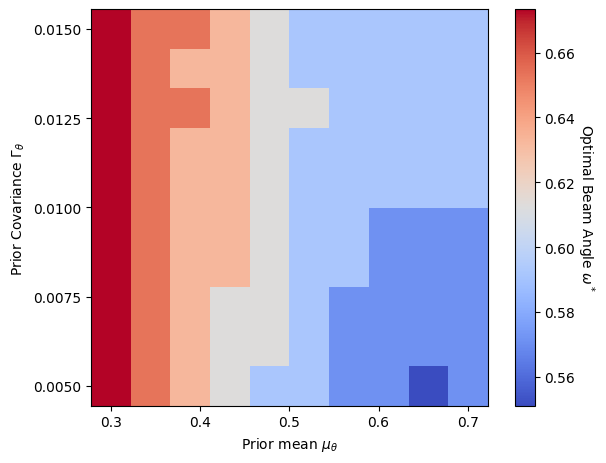

In [13]:
grid_len = 10
oed_list = []
d_vals = prior_experiment['d']
for ape_i in prior_experiment['ape']:
    smallest_ape_idx = np.argsort(ape_i)[0]
    oed_list.append(d_vals[smallest_ape_idx])
oed = np.array(oed_list).reshape(grid_len,grid_len,order='F')
x_grid = np.array(prior_experiment['mean']).reshape(grid_len, grid_len)
y_grid = np.array(prior_experiment['cov']).reshape(grid_len,grid_len)
plt.rcdefaults()
fig, ax = plt.subplots()
im = plt.imshow(oed, cmap='coolwarm', origin='lower')
cbar = plt.colorbar(im)
cbar.set_label('Optimal Beam Angle $\omega^*$', rotation=270, labelpad=15)
plotting_helpers.set_x_and_y_ticks(ax, x_grid, y_grid, num_x_ticks=5, num_y_ticks=5, x_dp=1, y_dp=4)
ax.set_xlabel('Prior mean $\mu_\\theta$')
ax.set_ylabel('Prior Covariance $\Gamma_\\theta$')
sns.set_theme(style='darkgrid')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'prior_effect_surface.pdf'), bbox_inches='tight')

To help us better understand the effect of the prior mean, let's plot the surrogate model output $y$ against $d$ for $\theta = 0.3$ and for $\theta = 0.7$:

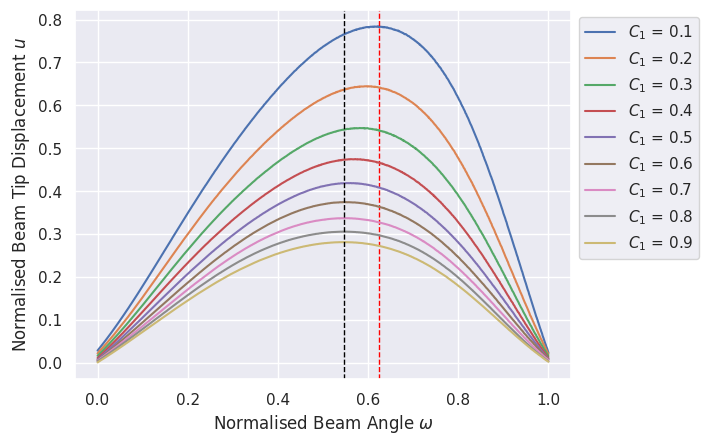

In [14]:
d_plot = jnp.linspace(0,1,1000).reshape(-1,1)
fix, ax = plt.subplots()
theta_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i, theta in enumerate(theta_vals):
    model_surface = beam_model.predict(theta, d_plot)
    sns.lineplot(x=d_plot.squeeze(), y=model_surface.squeeze(), label=f'$C_1$ = {theta:.1f}', color=palette[i])
    idx_max = jnp.argmax(model_surface.squeeze())
    d_max = d_plot[idx_max]
    if i == 0:
        ax.axvline(d_max, color='red', ls='--', lw=1)
    elif i == len(theta_vals)-1:
        ax.axvline(d_max, color='black', ls='--', lw=1)
ax.set_xlabel('Normalised Beam Angle $\omega$')
ax.set_ylabel('Normalised Beam Tip Displacement $u$')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(fig_save_dir, 'peak_beam_displacement_vs_angle.pdf'), bbox_inches='tight')

# Implications of Choosing a Sub-Optimal Design

## Under a 'Correct' Prior

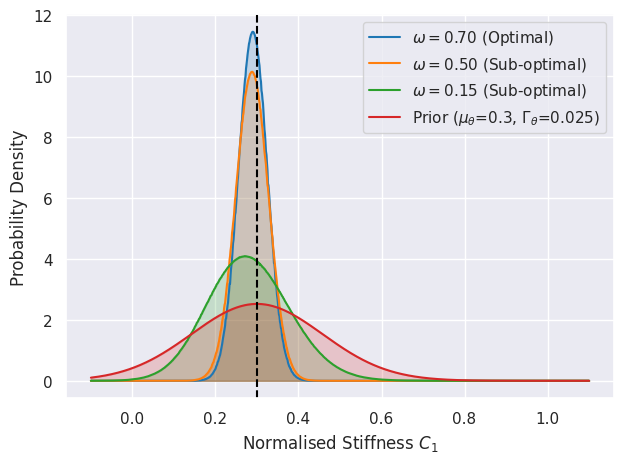

In [15]:
noise_cov = 0.001
prior_mean = 0.3
prior_cov = 0.025
true_theta = prior_mean
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, 
                                                                           prior_mean, prior_cov)
v_suboptimal_d = 0.15
suboptimal_d = 0.5
optimal_d = 0.7
v_suboptimal_y = likelihood.sample(true_theta, v_suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
suboptimal_y = likelihood.sample(true_theta, suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
optimal_y = likelihood.sample(true_theta, optimal_d, num_samples=1, rng=np.random.default_rng(np_seed))

theta_plot = np.linspace(-0.1, 1.1, 1000).reshape(-1,1)
pdfs = {f'Prior ($\mu_\\theta$={prior_mean:.1f}, $\Gamma_\\theta$={prior_cov:.3f})': jnp.exp(prior.logpdf(theta_plot)['logpdf']),
        f'$\omega = {v_suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, 
                                                                               v_suboptimal_y, v_suboptimal_d)['logpdf']),
        f'$\omega = {suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, suboptimal_y, suboptimal_d)['logpdf']),
        f'$\omega = {optimal_d:.2f}$ (Optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, optimal_y, optimal_d)['logpdf'])}
pdfs = dict(reversed(list(pdfs.items())))
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$')
ax = plt.gca()
plt.axvline(x=true_theta, color='black', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'suboptimal_correct_prior.pdf'), bbox_inches='tight')

In [16]:
# Summary statistics:
d_theta = theta_plot[1] - theta_plot[0]
theta = theta_plot.squeeze()
for key, pdf_i in pdfs.items():
    pdf_i = pdf_i.squeeze()
    mean = np.sum(d_theta*pdf_i*theta)
    var = np.sum(d_theta*pdf_i*(theta-mean)**2)
    mode = theta_plot[np.argmax(pdf_i)]
    print(f'{key} distribution: Mean = {mean}, Mode = {mode}, Variance = {var}')

$\omega = 0.70$ (Optimal) distribution: Mean = 0.2898648977279663, Mode = [0.29039039], Variance = 0.0012131298426538706
$\omega = 0.50$ (Sub-optimal) distribution: Mean = 0.2880375385284424, Mode = [0.28918919], Variance = 0.0015508797951042652
$\omega = 0.15$ (Sub-optimal) distribution: Mean = 0.2831534743309021, Mode = [0.27117117], Variance = 0.00987449660897255
Prior ($\mu_\theta$=0.3, $\Gamma_\theta$=0.025) distribution: Mean = 0.30085301399230957, Mode = [0.3], Variance = 0.023834964260458946


## Under an 'Incorrect' Prior

What about a scenario where our prior is misspecified? Same code as before, but we set a specific true_theta value:

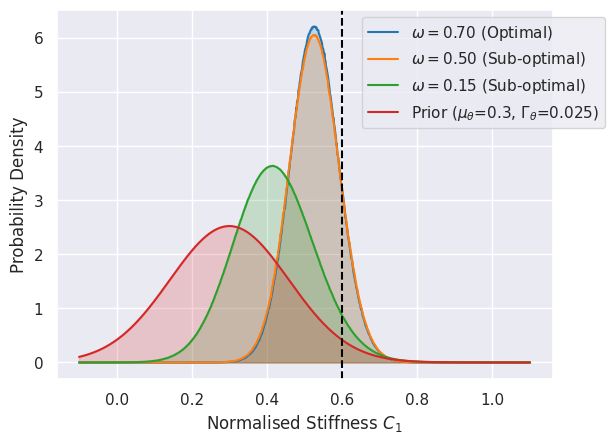

In [17]:
true_theta = 0.6
noise_cov = 0.001
prior_mean = 0.3
prior_cov = 0.025
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
laplace_approx = oed_toolbox.distributions.Posterior.laplace_approximation(beam_model, minimizer, noise_cov, 
                                                                           prior_mean, prior_cov)
v_suboptimal_d = 0.15
suboptimal_d = 0.5
optimal_d = 0.7
v_suboptimal_y = likelihood.sample(true_theta, v_suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
suboptimal_y = likelihood.sample(true_theta, suboptimal_d, num_samples=1, rng=np.random.default_rng(np_seed))
optimal_y = likelihood.sample(true_theta, optimal_d, num_samples=1, rng=np.random.default_rng(np_seed))

theta_plot = np.linspace(-0.1, 1.1, 1000).reshape(-1,1)
pdfs = {f'Prior ($\mu_\\theta$={prior_mean:.1f}, $\Gamma_\\theta$={prior_cov:.3f})': jnp.exp(prior.logpdf(theta_plot)['logpdf']),
        f'$\omega = {v_suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, 
                                                                               v_suboptimal_y, v_suboptimal_d)['logpdf']),
        f'$\omega = {suboptimal_d:.2f}$ (Sub-optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, suboptimal_y, suboptimal_d)['logpdf']),
        f'$\omega = {optimal_d:.2f}$ (Optimal)': jnp.exp(laplace_approx.logpdf(theta_plot, optimal_y, optimal_d)['logpdf'])}
pdfs = dict(reversed(list(pdfs.items())))
plotting_helpers.plot_distributions(pdfs, theta_plot, xlabel='Normalised Stiffness $C_1$', legend_loc='upper right')
ax = plt.gca()
plt.axvline(x=true_theta, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(0.6,1))
plt.savefig(os.path.join(fig_save_dir, 'suboptimal_incorrect_prior.pdf'), bbox_inches='tight')

In [18]:
# Summary statistics:
d_theta = theta_plot[1] - theta_plot[0]
theta = theta_plot.squeeze()
for key, pdf_i in pdfs.items():
    pdf_i = pdf_i.squeeze()
    mean = np.sum(d_theta*pdf_i*theta)
    var = np.sum(d_theta*pdf_i*(theta-mean)**2)
    mode = theta_plot[np.argmax(pdf_i)]
    print(f'{key} distribution: Mean = {mean}, Mode = {mode}, Variance = {var}')

$\omega = 0.70$ (Optimal) distribution: Mean = 0.5257865786552429, Mode = [0.52702703], Variance = 0.0041422611102461815
$\omega = 0.50$ (Sub-optimal) distribution: Mean = 0.5246280431747437, Mode = [0.52942943], Variance = 0.004315807484090328
$\omega = 0.15$ (Sub-optimal) distribution: Mean = 0.4083775281906128, Mode = [0.41531532], Variance = 0.011338001117110252
Prior ($\mu_\theta$=0.3, $\Gamma_\theta$=0.025) distribution: Mean = 0.30085301399230957, Mode = [0.3], Variance = 0.023834964260458946
